In [4]:
pip install pandasql

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26800 sha256=60ffb50e08067279bef47f0b7cdc3dd226ec81a488fecf9b0bfa85f25ac10756
  Stored in directory: c:\users\rvanjani\appdata\local\pip\cache\wheels\68\5d\a5\edc271b998f909801d7956959f699b976cc9896075dc47c153
Successfully built pandasql
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import necessary packages
import pandas as pd
import numpy as np
import sqlite3
from pandasql import sqldf
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

# load in data sets - some were not used in final analysis
boxoffice = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_table('zippedData/rt.movie_info.tsv.gz')
reviews = pd.read_table('zippedData/rt.reviews.tsv.gz', encoding='windows-1252')
movies = pd.read_csv('zippedData/tmdb.movies.csv.gz', index_col=0)
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', index_col=0)

# connect to database
conn = sqlite3.connect('zippedData/im.db')

pysqldf = lambda q: sqldf(q, globals())

In [5]:
# join "movie_basics" and "movie_ratings" tables
joined = pd.read_sql(
    """SELECT * 
    FROM movie_basics mb 
     JOIN movie_ratings mr 
      ON mb.movie_id=mr.movie_id 
     JOIN directors d 
      ON mb.movie_id = d.movie_id 
     JOIN persons p 
       ON d.person_id = p.person_id;""", conn)

# join "movie_budgets" and "movies" data with "joined" data above
q = """SELECT * FROM joined j JOIN movie_budgets mb ON mb.movie=j.primary_title JOIN movies m ON m.original_title=j.original_title"""
master_df = pysqldf(q).drop_duplicates(subset='primary_title', keep='first')

In [6]:
master_df.shape

(1749, 28)

In [7]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1749 entries, 0 to 7427
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1749 non-null   object 
 1   primary_title       1749 non-null   object 
 2   original_title      1749 non-null   object 
 3   start_year          1749 non-null   int64  
 4   runtime_minutes     1731 non-null   float64
 5   genres              1748 non-null   object 
 6   averagerating       1749 non-null   float64
 7   numvotes            1749 non-null   int64  
 8   person_id           1749 non-null   object 
 9   primary_name        1749 non-null   object 
 10  birth_year          1193 non-null   float64
 11  death_year          13 non-null     float64
 12  primary_profession  1749 non-null   object 
 13  id                  1749 non-null   int64  
 14  release_date        1749 non-null   object 
 15  movie               1749 non-null   object 
 16  produc

In [8]:
master_df.describe()

,start_year,runtime_minutes,averagerating,numvotes,birth_year,death_year,id,id,popularity,vote_average,vote_count
count,1749.000000,1731.000000,1749.000000,1.749000e+03,1193.000000,13.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000
mean,2013.451115,104.975737,6.232704,9.761625e+04,1965.418273,2014.846154,50.405374,198745.252716,11.167816,6.178616,1734.321326
std,2.441896,17.788432,1.103357,1.546309e+05,10.679839,2.764241,28.589011,137188.031855,8.124123,1.035718,2687.410413
min,2010.000000,41.000000,1.600000,5.000000e+00,1930.000000,2010.000000,1.000000,189.000000,0.600000,0.000000,1.000000
25%,2011.000000,93.000000,5.600000,5.461000e+03,1960.000000,2013.000000,26.000000,71859.000000,6.495000,5.600000,111.000000
50%,2013.000000,103.000000,6.400000,4.165900e+04,1966.000000,2015.000000,50.000000,181283.000000,9.808000,6.200000,686.000000
75%,2015.000000,115.000000,7.000000,1.186780e+05,1973.000000,2016.000000,75.000000,309919.000000,14.530000,6.800000,2111.000000
max,2019.000000,180.000000,9.200000,1.841066e+06,1994.000000,2019.000000,100.000000,566114.000000,80.773000,10.000000,22186.000000


In [11]:
# drop unneccessary columns
new_master_df = master_df.drop(["original_title", "id", "start_year", "movie", "title", "genre_ids", "original_language", "birth_year", "death_year", 'release_date'], axis=1)

# rename "duplicate" columns to reflect data source
new_master_df = new_master_df.rename(columns={"vote_average": "tmdb_vote_average",
                                              "vote_count": "tmdb_vote_count", 
                                              "averagerating": "imdb_average_rating", 
                                              "numvotes": "imdb_vote_count"})

# convert the "genres" and "primary_profession" column into a list
new_master_df["genres"] = new_master_df["genres"].str.split(',')
new_master_df["primary_profession"] = new_master_df["primary_profession"].str.split(',')
new_master_df

# convert "domestic_gross", "production_budget", "worldwide_gross" to integers 
new_master_df['domestic_gross'] = new_master_df['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(int)
new_master_df['production_budget'] = new_master_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(int)
new_master_df['worldwide_gross'] = new_master_df['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(int)
final_master_df = new_master_df
final_master_df

# calculate "domestic_profit" and "worldwide_profit" by subtracting "production_budget" from "domestic_gross" and "worldwide_gross"
final_master_df['domestic_profit'] = final_master_df['domestic_gross'] - final_master_df['production_budget']
final_master_df['worldwide_profit'] = final_master_df['worldwide_gross'] - final_master_df['production_budget']
final_master_df.head(3)

C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\245131667.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  new_master_df['domestic_gross'] = new_master_df['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(int)
C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\245131667.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  new_master_df['production_budget'] = new_master_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(int)
C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\245131667.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expr

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,person_id,primary_name,primary_profession,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
0,tt0249516,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294
5,tt0326592,The Overnight,88.0,None,7.5,24,nm1208371,Jed I. Goodman,"[camera_department, writer, producer]",200000,1109808,1165996,6.576,6.0,200,909808,965996
7,tt0337692,On the Road,124.0,"[Adventure, Drama, Romance]",6.1,37886,nm0758574,Walter Salles,"[director, producer, writer]",25000000,720828,9313302,8.919,5.6,518,-24279172,-15686698


In [12]:
final_master_df.shape

(1749, 17)

In [13]:
final_master_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1749 entries, 0 to 7427
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   movie_id             1749 non-null   object 
 1   primary_title        1749 non-null   object 
 2   runtime_minutes      1731 non-null   float64
 3   genres               1748 non-null   object 
 4   imdb_average_rating  1749 non-null   float64
 5   imdb_vote_count      1749 non-null   int64  
 6   person_id            1749 non-null   object 
 7   primary_name         1749 non-null   object 
 8   primary_profession   1749 non-null   object 
 9   production_budget    1749 non-null   int32  
 10  domestic_gross       1749 non-null   int32  
 11  worldwide_gross      1749 non-null   int32  
 12  popularity           1749 non-null   float64
 13  tmdb_vote_average    1749 non-null   float64
 14  tmdb_vote_count      1749 non-null   int64  
 15  domestic_profit      1749 non-null   i

In [14]:
final_master_df.describe()

,runtime_minutes,imdb_average_rating,imdb_vote_count,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
count,1731.000000,1749.000000,1.749000e+03,1.749000e+03,1.749000e+03,1.749000e+03,1749.000000,1749.000000,1749.000000,1.749000e+03,1.749000e+03
mean,104.975737,6.232704,9.761625e+04,3.835764e+07,4.775776e+07,1.175821e+08,11.167816,6.178616,1734.321326,9.400115e+06,7.922442e+07
std,17.788432,1.103357,1.546309e+05,5.152133e+07,7.766330e+07,2.124155e+08,8.124123,1.035718,2687.410413,5.347464e+07,1.740217e+08
min,41.000000,1.600000,5.000000e+00,9.000000e+03,0.000000e+00,0.000000e+00,0.600000,0.000000,1.000000,-2.019413e+08,-1.104502e+08
25%,93.000000,5.600000,5.461000e+03,5.000000e+06,1.034589e+06,3.324070e+06,6.495000,5.600000,111.000000,-1.019274e+07,-1.524154e+06
50%,103.000000,6.400000,4.165900e+04,2.000000e+07,2.026882e+07,3.678704e+07,9.808000,6.200000,686.000000,-7.682620e+05,1.383608e+07
75%,115.000000,7.000000,1.186780e+05,4.750000e+07,5.789180e+07,1.236606e+08,14.530000,6.800000,2111.000000,1.792855e+07,7.730918e+07
max,180.000000,9.200000,1.841066e+06,4.106000e+08,7.000596e+08,2.048134e+09,80.773000,10.000000,22186.000000,5.000596e+08,1.748134e+09


In [15]:
# correlation between "popularity" and "worldwide_profit"
popularity_correlation = final_master_df['popularity'].corr(final_master_df['worldwide_profit'])
popularity_correlation

0.5973826421033719

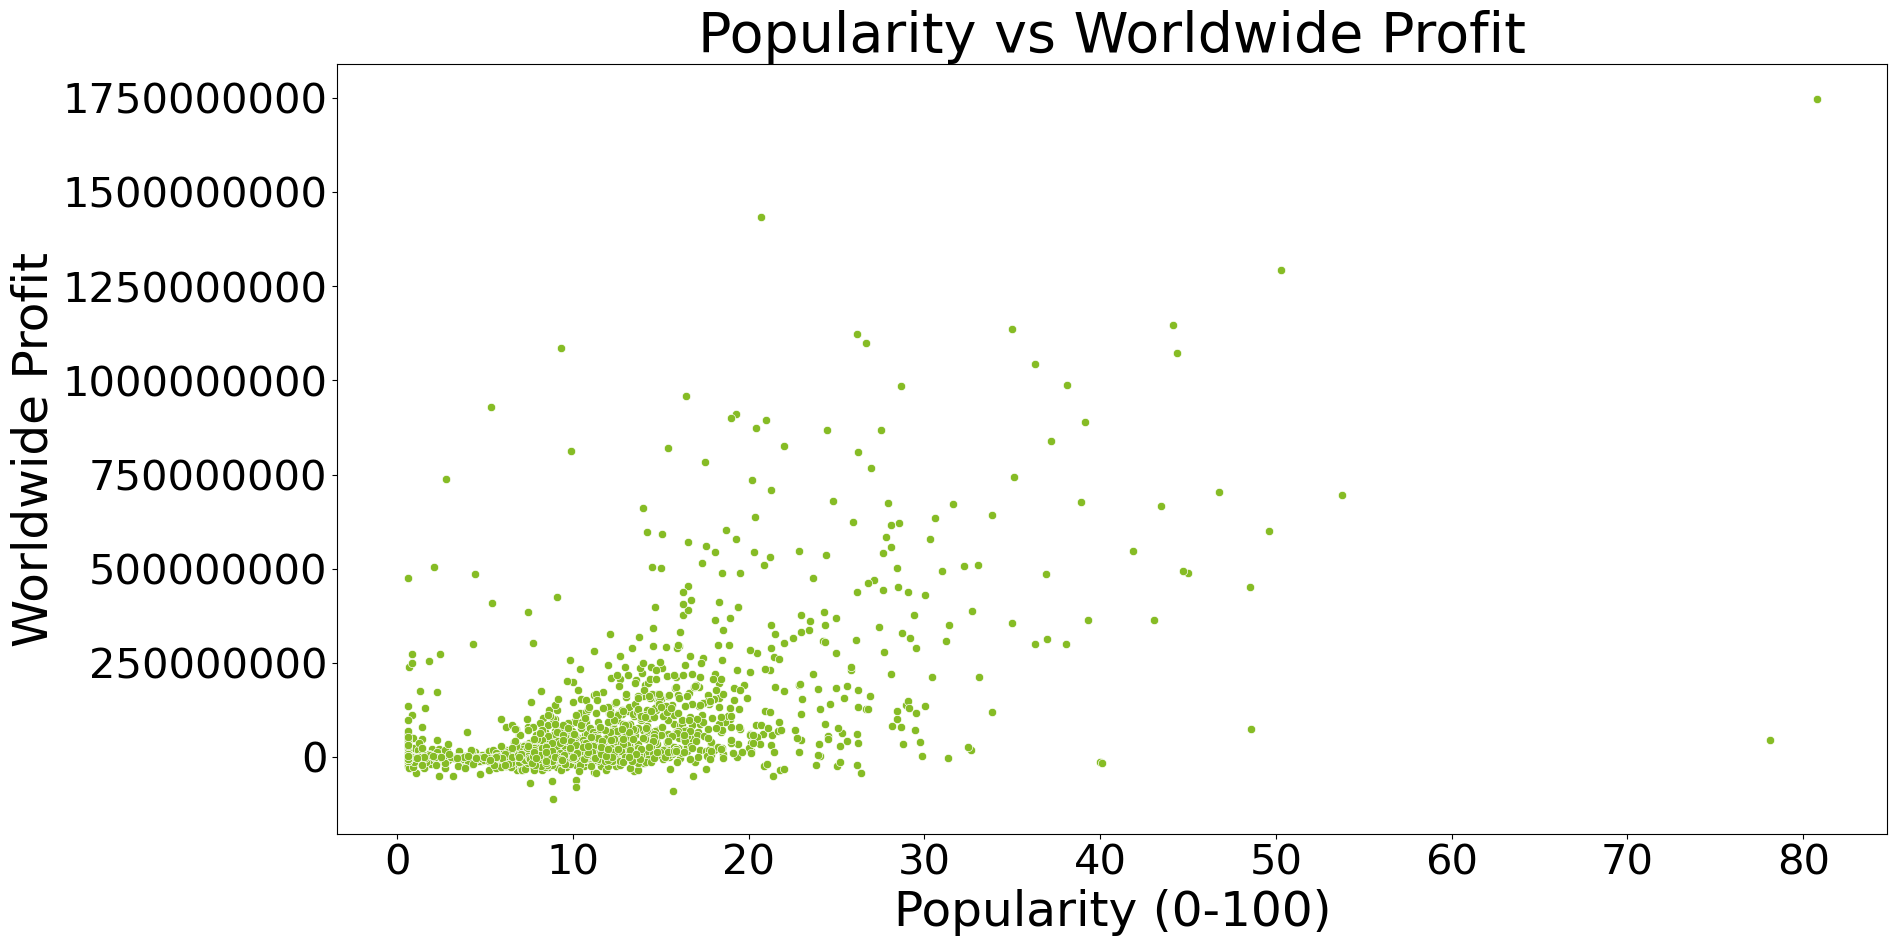

In [16]:
# scatterplot showing the relationship between "popularity" and "worldwide_profit"
plt.figure(figsize=(20, 10))
sns.scatterplot(y=final_master_df['worldwide_profit'], 
                x=final_master_df['popularity'], color="#86BC25")

# set barplot title and axes labels
plt.title(label = "Popularity vs Worldwide Profit", fontsize=40)
plt.xlabel("Popularity (0-100)", fontsize=35)
plt.ylabel("Worldwide Profit", fontsize=35)

# set x and y tick size
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(size = 30)
plt.yticks(size = 30);

In [17]:
# correlation between "imdb_average_rating" and "worldwide_profit"
average_rating = final_master_df['imdb_average_rating'].corr(final_master_df['worldwide_profit'])
average_rating

0.25093081799095923

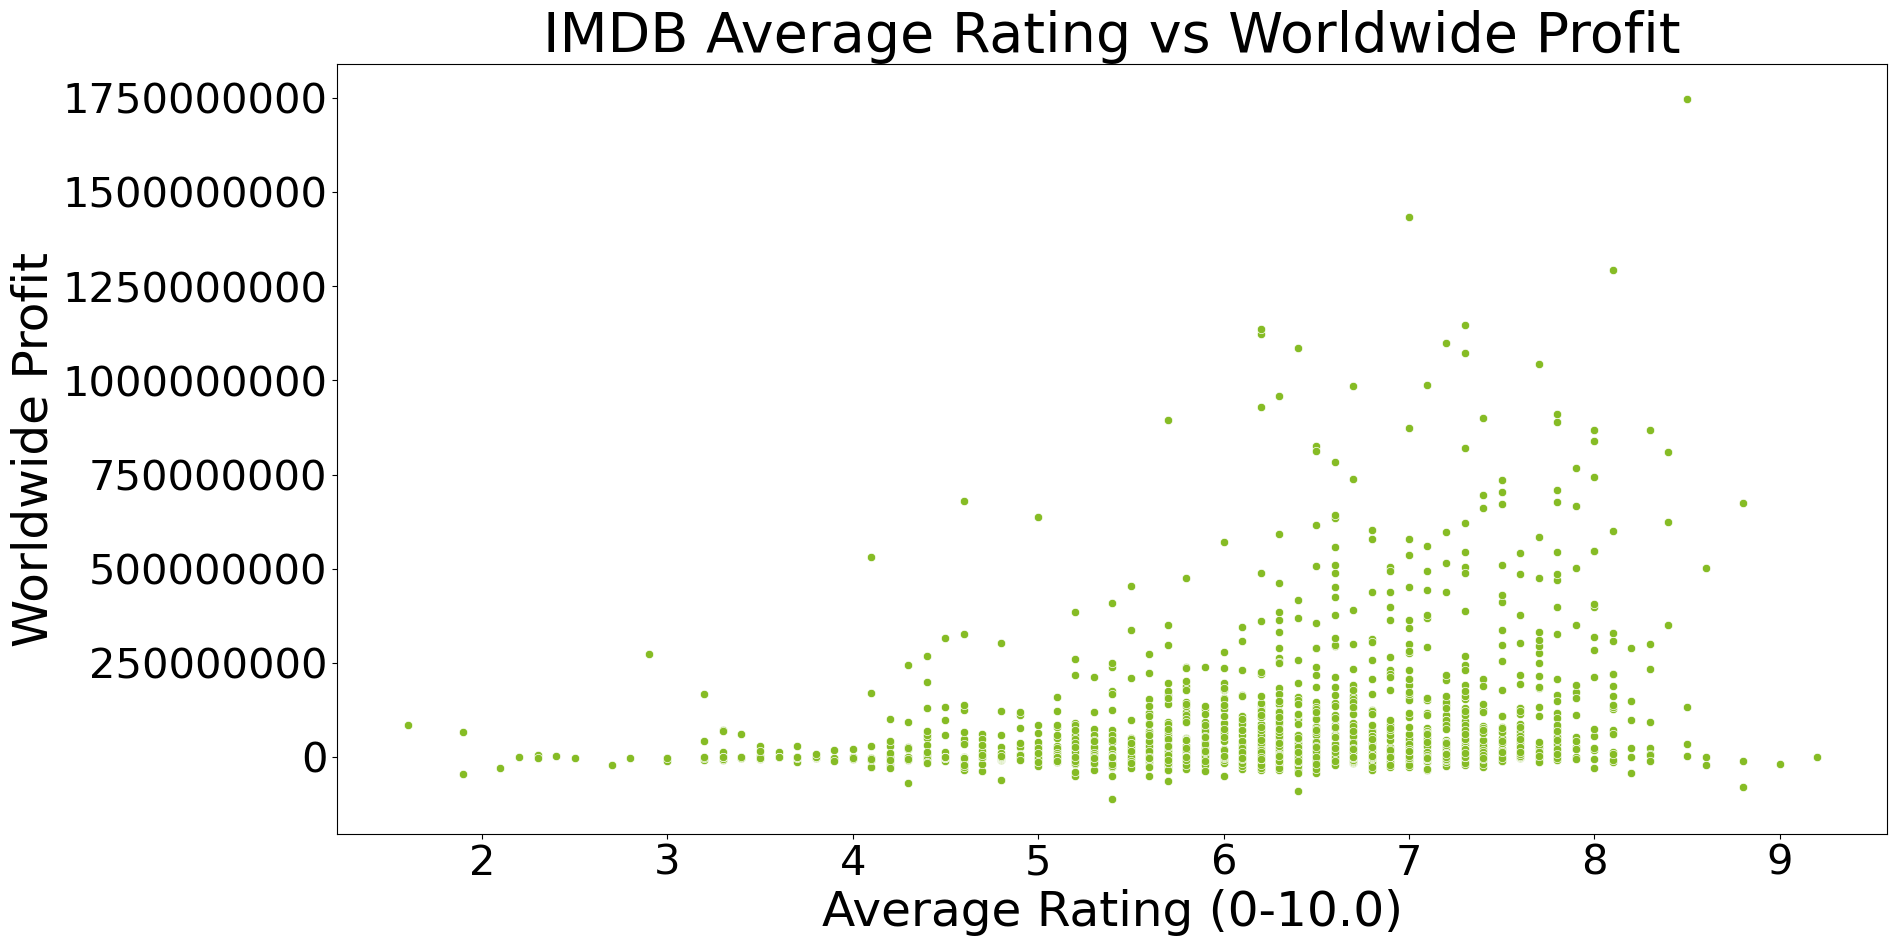

In [18]:
# scatterplot showing the relationship between "popularity" and "worldwide_profit"
plt.figure(figsize=(20, 10))
sns.scatterplot(y=final_master_df['worldwide_profit'], 
            x=final_master_df['imdb_average_rating'], color="#86BC25")

# set barplot title and axes labels
plt.title(label = "IMDB Average Rating vs Worldwide Profit", fontsize=40)
plt.xlabel("Average Rating (0-10.0)", fontsize=35)
plt.ylabel("Worldwide Profit", fontsize=35)

# set x and y tick size
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(size = 30)
plt.yticks(size = 30);

In [19]:
# explode table based on genres
final = final_master_df
final = final.dropna()
final.reset_index(drop=True)
final = final.explode('genres')
final.head(3)

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,person_id,primary_name,primary_profession,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
0,tt0249516,Foodfight!,91.0,Action,1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294
0,tt0249516,Foodfight!,91.0,Animation,1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294
0,tt0249516,Foodfight!,91.0,Comedy,1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294


C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\285410623.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  comedy = final[final['genres'] == 'Comedy'].mean()
C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\285410623.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  action = final[final['genres'] == 'Action'].mean()
C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\285410623.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In add

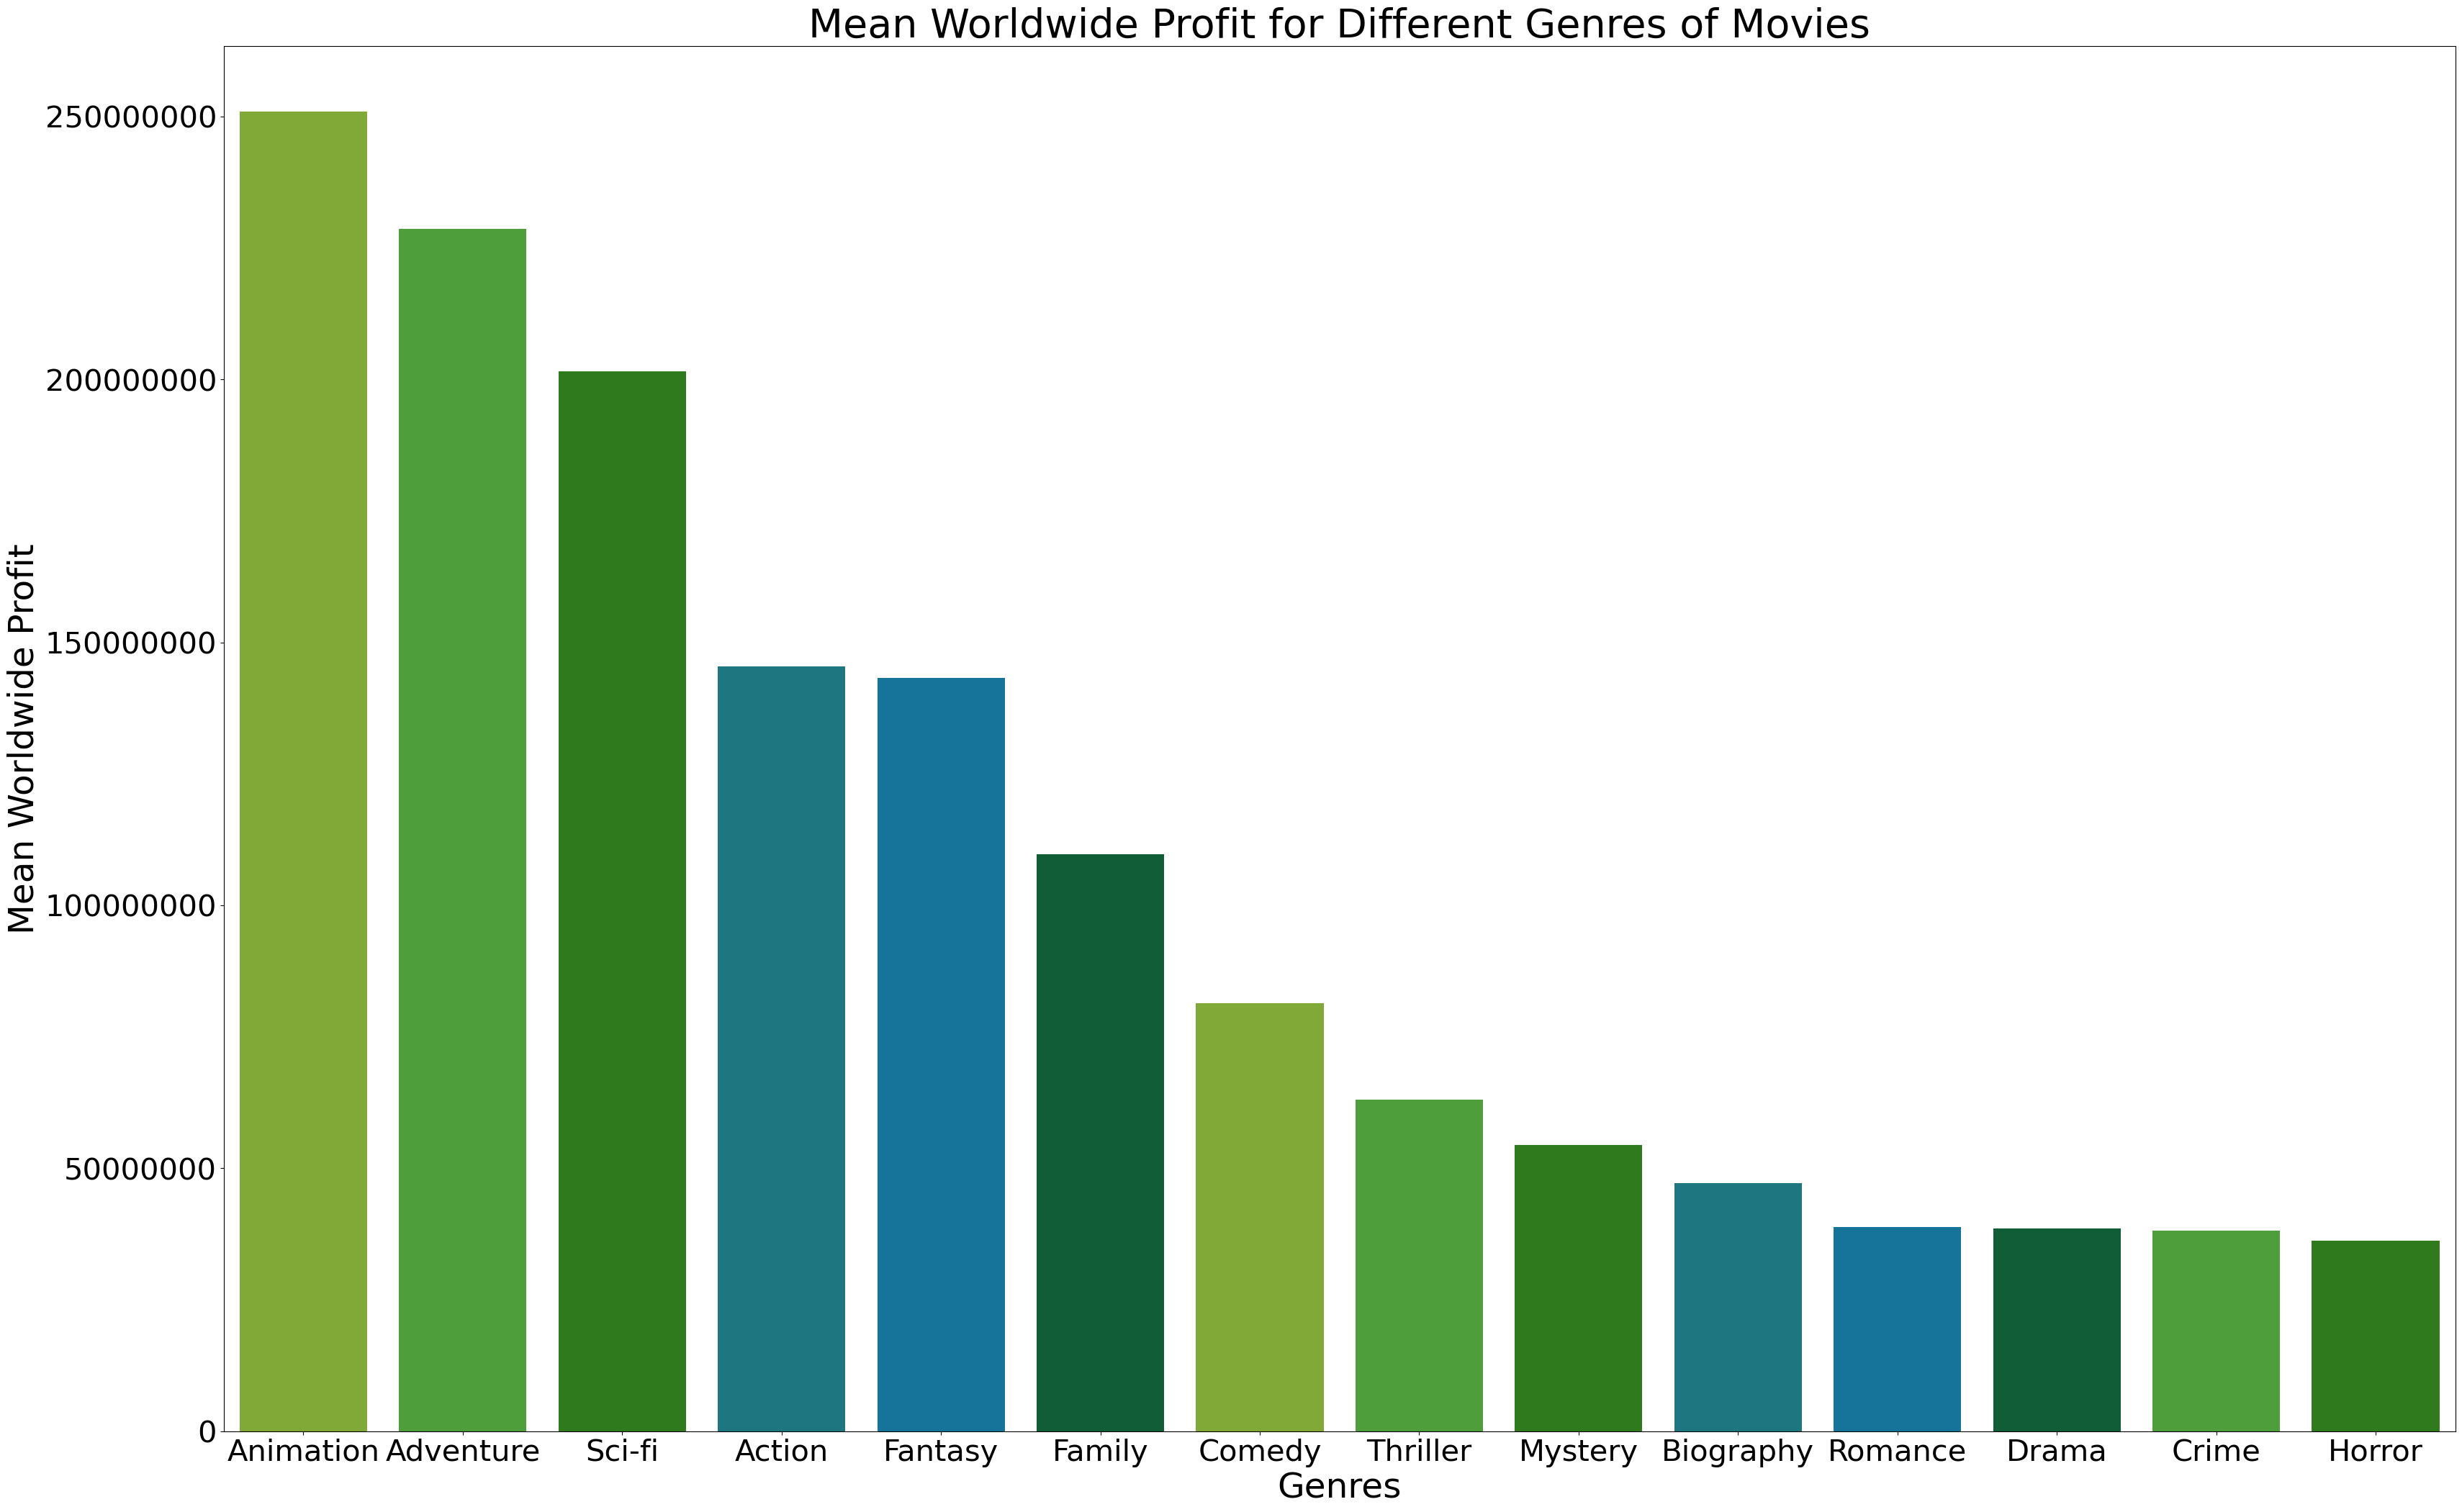

In [20]:
# find the mean of different genres of movies
comedy = final[final['genres'] == 'Comedy'].mean()
action = final[final['genres'] == 'Action'].mean()
animation = final[final['genres'] == 'Animation'].mean()
drama = final[final['genres'] == 'Drama'].mean()
horror = final[final['genres'] == 'Horror'].mean()
mystery = final[final['genres'] == 'Mystery'].mean()
scifi = final[final['genres'] == 'Sci-Fi'].mean()
adventure = final[final['genres'] == 'Adventure'].mean()
romance = final[final['genres'] == 'Romance'].mean()
thriller = final[final['genres'] == 'Thriller'].mean()
crime = final[final['genres'] == 'Crime'].mean()
biography = final[final['genres'] == 'Biography'].mean()
fantasy = final[final['genres'] == 'Fantasy'].mean() 
family = final[final['genres'] == 'Family'].mean()


# create dictionary of genres and means
genre_profit = {"Comedy":comedy, "Action": action, "Animation": animation, "Drama": drama, "Horror": horror,
               "Mystery": mystery, "Sci-fi": scifi, "Adventure": adventure, "Romance": romance, "Thriller": thriller, 
                "Crime": crime, "Biography": biography, "Fantasy": fantasy, "Family": family}

# create a dataframe from the dictionary above
mean_df = pd.DataFrame(genre_profit)

# get worldwide profit; sort and prepare for graph below
genres = mean_df.iloc[[10]]
genres = genres.T.sort_values("worldwide_profit", ascending=False)
genres = genres.reset_index()

# graph mean worldwide profit for different genres of movies
colors = ['#86BC25', '#43B02A', '#26890D', '#0D8390', 
          '#007CB0', '#046A38', '#86BC25','#43B02A', 
          '#26890D', '#0D8390', '#007CB0', '#046A38', 
          '#43B02A', '#26890D']
plt.figure(figsize=(40, 25))
sns.barplot(x="index", y="worldwide_profit", data=genres, palette = colors)

# set barplot title and axes labels
plt.xlabel('Genres', fontsize = 35)
plt.ylabel('Mean Worldwide Profit', fontsize = 35)
plt.title('Mean Worldwide Profit for Different Genres of Movies', fontsize = 40);

# set x and y tick size
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(size = 30)
plt.yticks(size = 30);

In [21]:
genre_budget = final.groupby('genres').mean()['production_budget'].sort_values(ascending=False).to_frame()
genre_budget.head(5)

C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\2287368578.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  genre_budget = final.groupby('genres').mean()['production_budget'].sort_values(ascending=False).to_frame()


,production_budget
genres,
Adventure,9.811510e+07
Animation,9.103398e+07
Fantasy,7.837578e+07
Sci-Fi,7.615998e+07
Action,7.310083e+07


In [22]:
# filter by directors who have produced 5+ movies
final_direct = final.groupby("primary_name").filter(lambda x: len(x) >= 5)

In [23]:
directors_profit = final_direct.groupby('primary_name').mean()['worldwide_gross'].sort_values(ascending=False).to_frame()
directors_profit.head(3)

C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\1786458473.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  directors_profit = final_direct.groupby('primary_name').mean()['worldwide_gross'].sort_values(ascending=False).to_frame()


,worldwide_gross
primary_name,
Joss Whedon,1.460475e+09
Anthony Russo,1.300869e+09
Kyle Balda,1.097532e+09


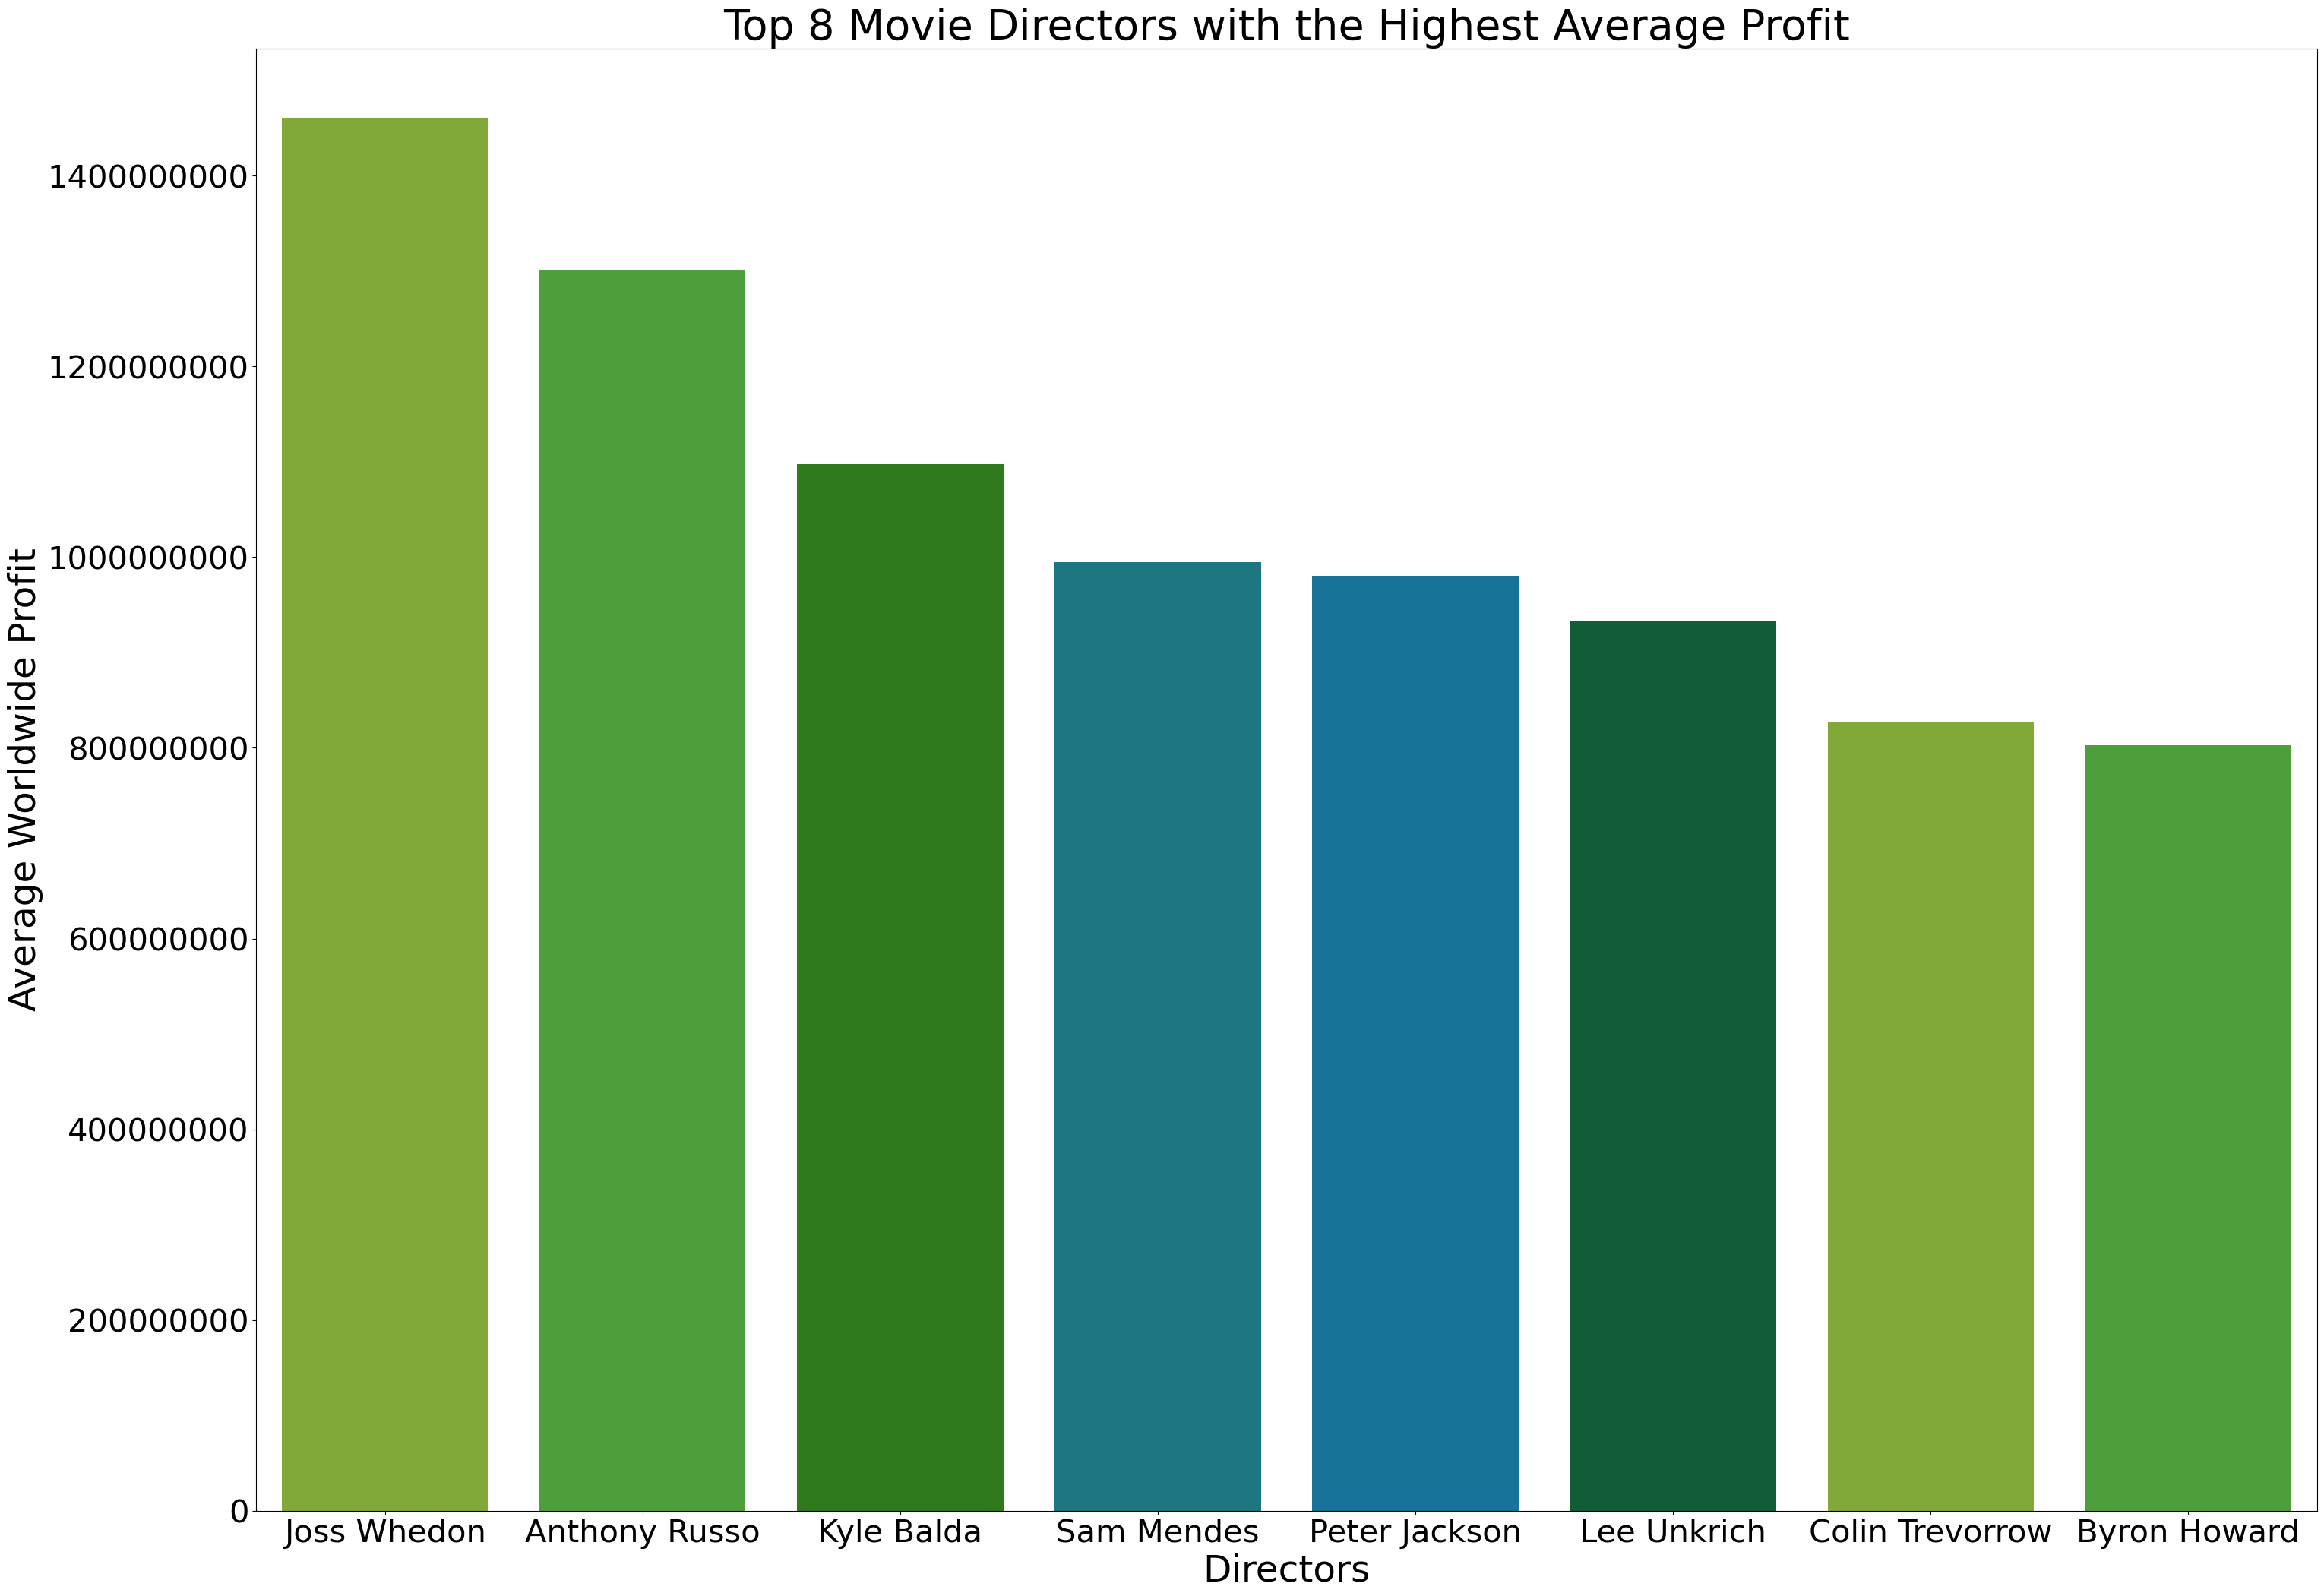

In [24]:
# create barplot of the top 8 directors with Deloitte color palette
d = directors_profit.head(8)
plt.figure(figsize=(35, 25))
colors = ['#86BC25', '#43B02A', '#26890D', '#0D8390', 
          '#007CB0', '#046A38', '#86BC25','#43B02A', 
          '#26890D', '#0D8390', '#007CB0', '#046A38', 
          '#43B02A', '#26890D']

ax = sns.barplot(x=d.index, y= d['worldwide_gross'], palette = colors)  

# set barplot title and axes labels
plt.title(label = "Top 8 Movie Directors with the Highest Average Profit", fontsize=40)
plt.xlabel("Directors", fontsize=35)
plt.ylabel("Average Worldwide Profit", fontsize=35)

# set x and y tick size and format tick labels
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(size = 30)
plt.yticks(size = 30);

In [25]:
# numerical summary of the data above
directors_profit = final.groupby('primary_name').mean()['worldwide_gross'].sort_values(ascending=False).to_frame()
directors_profit.head(8)

C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\3302008087.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  directors_profit = final.groupby('primary_name').mean()['worldwide_gross'].sort_values(ascending=False).to_frame()


,worldwide_gross
primary_name,
Joss Whedon,1.460475e+09
Anthony Russo,1.300869e+09
Adam Green,1.272470e+09
Kyle Balda,1.097532e+09
Sam Mendes,9.950740e+08
Peter Jackson,9.804142e+08
Lee Unkrich,9.334438e+08
Yarrow Cheney,8.867505e+08


In [26]:
# top 3 directors
directors_profit.head(3)

,worldwide_gross
primary_name,
Joss Whedon,1.460475e+09
Anthony Russo,1.300869e+09
Adam Green,1.272470e+09


In [27]:
animation = final_direct[final_direct['genres'] == 'Animation']
directors_profit_animation = animation.groupby('primary_name').mean()['worldwide_gross'].sort_values(ascending=False).to_frame()
directors_profit_animation.head(3)

C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\3594909068.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  directors_profit_animation = animation.groupby('primary_name').mean()['worldwide_gross'].sort_values(ascending=False).to_frame()


,worldwide_gross
primary_name,
Brad Bird,1.242521e+09
Kyle Balda,1.097532e+09
Andrew Stanton,1.021215e+09


In [28]:
adventure = final_direct[final_direct['genres'] == 'Adventure']
directors_profit_adventure = adventure.groupby('primary_name').mean()['worldwide_gross'].sort_values(ascending=False).to_frame()
directors_profit_adventure.head(3)

C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\2432863147.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  directors_profit_adventure = adventure.groupby('primary_name').mean()['worldwide_gross'].sort_values(ascending=False).to_frame()


,worldwide_gross
primary_name,
Colin Trevorrow,1.648855e+09
Joss Whedon,1.460475e+09
Ryan Coogler,1.348258e+09


In [29]:
scifi = final_direct[final_direct['genres'] == 'Sci-Fi']
directors_profit_scifi = scifi.groupby('primary_name').mean()['worldwide_gross'].sort_values(ascending=False).to_frame()
directors_profit_scifi.head(3)

C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\3476358495.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  directors_profit_scifi = scifi.groupby('primary_name').mean()['worldwide_gross'].sort_values(ascending=False).to_frame()


,worldwide_gross
primary_name,
Colin Trevorrow,1.648855e+09
Joss Whedon,1.460475e+09
Ryan Coogler,1.348258e+09


In [30]:
# runtime statistics across all genres
runtime = pd.DataFrame(final, columns=['runtime_minutes'])
print(runtime.describe()) 

       runtime_minutes
count      4293.000000
mean        106.106918
std          17.402236
min          41.000000
25%          94.000000
50%         104.000000
75%         116.000000
max         180.000000


In [31]:
# profitability statistics across all genres
profit = pd.DataFrame(final, columns=['worldwide_profit'])
print(profit.describe())

       worldwide_profit
count      4.293000e+03
mean       8.924564e+07
std        1.867543e+08
min       -1.104502e+08
25%       -1.614407e+06
50%        1.779650e+07
75%        9.080884e+07
max        1.748134e+09


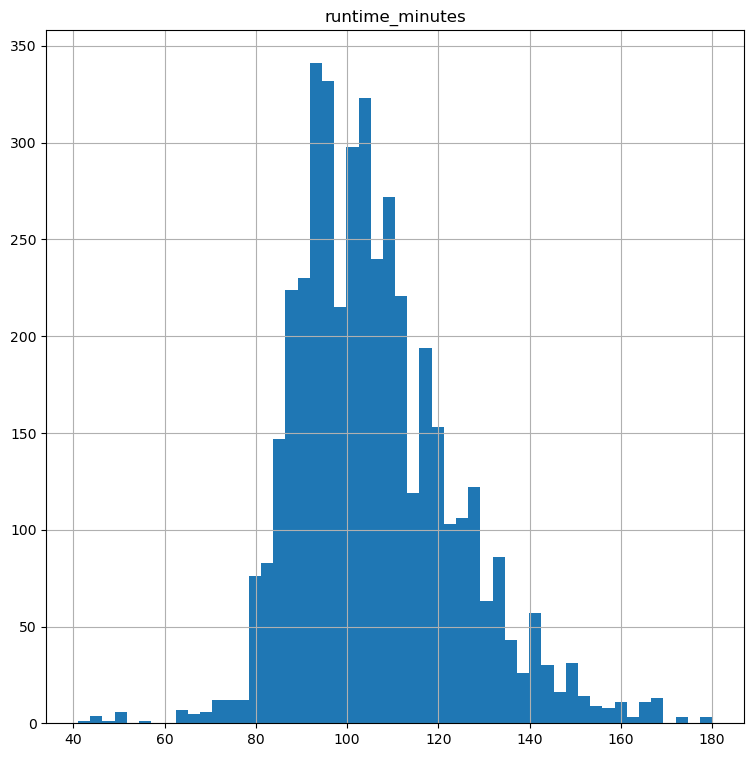

In [32]:
# histogram to show the distribution of "runtime"
pd.DataFrame(runtime).hist(bins='auto',figsize=(9,9));

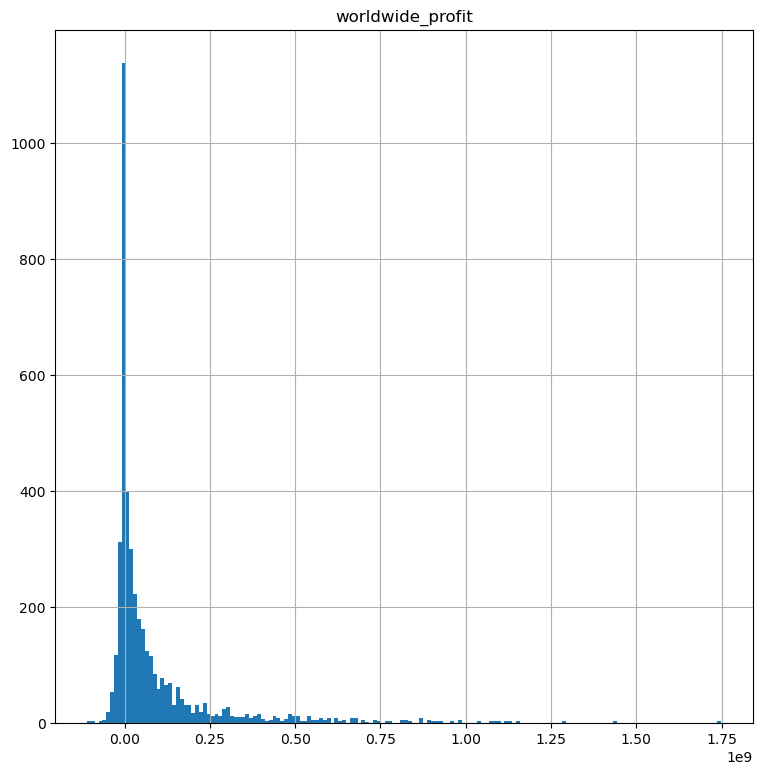

In [33]:
pd.DataFrame(profit).hist(bins='auto',figsize=(9,9));

In [34]:
# calculating the confidence interval within 1 standard deviation of the mean. A 68% chance that the runtime value would 
# fall in this range
stats.norm.interval(0.68, loc=runtime.mean(), scale=runtime.std())

(array([88.80112739]), array([123.41270908]))

In [35]:
sample_df1 = final[final['runtime_minutes'].between(87.29524865, 122.67584961, inclusive=True)]
sample_df1.head(3)

C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\1385116085.py:1: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  sample_df1 = final[final['runtime_minutes'].between(87.29524865, 122.67584961, inclusive=True)]


,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,person_id,primary_name,primary_profession,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
0,tt0249516,Foodfight!,91.0,Action,1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294
0,tt0249516,Foodfight!,91.0,Animation,1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294
0,tt0249516,Foodfight!,91.0,Comedy,1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294


In [36]:
#mean lowered in this range
sample_df1['worldwide_profit'].describe()

count    3.144000e+03
mean     6.961729e+07
std      1.453296e+08
min     -1.104502e+08
25%     -2.000000e+06
50%      1.406408e+07
75%      7.482962e+07
max      1.122470e+09
Name: worldwide_profit, dtype: float64

In [37]:
# sample of all runtimes within the range of 87.29 to 122.67 mins
group_runtime = sample_df1['runtime_minutes']

# the respective worldwide 
group_profit = sample_df1['worldwide_profit']

t_statistic, p_value = stats.ttest_ind(group_runtime,group_profit)

alpha = 0.05

In [38]:
# results interpretation
if p_value < alpha:
    print("Reject null hypothesis, a runtime between 87.3 and 122.7 minutes will positively impact profitability")
else:
    print("Fail to reject null hypothesis, a runtime between 87.3 and 122.7 minutes will negatively impact or not impact profitability")

Reject null hypothesis, a runtime between 87.3 and 122.7 minutes will positively impact profitability


In [39]:
stats.norm.interval(0.95, loc=runtime.mean(), scale=runtime.std())

(array([71.99916229]), array([140.21467419]))

In [40]:
sample_df2 = final[final['runtime_minutes'].between(0, 70.1199682, inclusive=True)]
sample_df3 = final[final['runtime_minutes'].between(70.1199682, 87.29524865, inclusive=True)]
sample_df4 = final[final['runtime_minutes'].between(87.29524865, 122.67584961, inclusive=True)]
sample_df5 = final[final['runtime_minutes'].between(122.67584961, 139.85113007, inclusive=True)]
sample_df6 = final[final['runtime_minutes'].between(139.85113007, 180, inclusive=True)]

C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\2588363845.py:1: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  sample_df2 = final[final['runtime_minutes'].between(0, 70.1199682, inclusive=True)]
C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\2588363845.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  sample_df3 = final[final['runtime_minutes'].between(70.1199682, 87.29524865, inclusive=True)]
C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\2588363845.py:3: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  sample_df4 = final[final['runtime_minutes'].between(87.29524865, 122.67584961, inclusive=True)]
C:\Users\rvanjani\AppData\Local\Temp\ipykernel_81716\2588363845.py:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  sample_df5

In [41]:
#no movies between these runtimes in our cleaned dataframe
sample_df2['worldwide_profit'].describe()

count    3.100000e+01
mean     3.091837e+07
std      8.844154e+07
min     -1.990318e+07
25%     -6.250000e+05
50%      1.151520e+07
75%      2.014561e+07
max      4.748365e+08
Name: worldwide_profit, dtype: float64

In [42]:
sample_df3['worldwide_profit'].describe() 

count    4.070000e+02
mean     2.934803e+07
std      8.461737e+07
min     -4.888407e+07
25%     -1.400000e+06
50%      1.659955e+06
75%      3.335931e+07
max      8.117505e+08
Name: worldwide_profit, dtype: float64

In [43]:
sample_df4['worldwide_profit'].describe() 

count    3.144000e+03
mean     6.961729e+07
std      1.453296e+08
min     -1.104502e+08
25%     -2.000000e+06
50%      1.406408e+07
75%      7.482962e+07
max      1.122470e+09
Name: worldwide_profit, dtype: float64

In [44]:
sample_df5['worldwide_profit'].describe()

count    5.020000e+02
mean     1.706217e+08
std      2.603411e+08
min     -5.033500e+07
25%      4.868073e+06
50%      6.023084e+07
75%      2.281781e+08
max      1.433855e+09
Name: worldwide_profit, dtype: float64

In [45]:
sample_df6['worldwide_profit'].describe()

count    2.090000e+02
mean     3.143520e+08
std      3.767300e+08
min     -2.277337e+07
25%      1.325700e+07
50%      1.493740e+08
75%      5.472714e+08
max      1.748134e+09
Name: worldwide_profit, dtype: float64

In [51]:
group_runtime1 = sample_df6['runtime_minutes']
group_profit1 = sample_df6['worldwide_profit']

t_statistic1, p_value1 = stats.ttest_ind(group_runtime1, group_profit1)

alpha = 0.05

In [53]:
# results interpretation
if p_value1 < alpha:
    print("Reject null hypothesis, a runtime between 140 and 180 minutes will positively impact profitability")
else:
    print("Fail to reject null hypothesis, a runtime between 140 and 180 minutes will negatively impact or not impact profitabilty");

Reject null hypothesis, a runtime between 140 and 180 minutes will positively impact profitability
